<h2> After performing centwav at 15ppm, then grouping with bw=2. Retention correction applied </h2>

Retention correction allowed a peak to be missing from ~20% of the data (100 samples) and still count as a "well-behaved peak". The default setting is 1.

Remember, this dataset is weird. It has replicates of all measurements. Make sure to split them before doing and ML stuff. It'll screw up your cross-validation completely.

Also, samples were run in 3 batches. I didn't take that into account in the xcms code, so all three are present currently in the feature table. You might want to repeat xcms with the batches separated at some point

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp

%matplotlib inline

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def remove_zero_columns(X, threshold=1e-20):
    # convert zeros to nan, drop all nan columns, the replace leftover nan with zeros
    X_non_zero_colum = X.replace(0, np.nan).dropna(how='all', axis=1).replace(np.nan, 0)
    #.dropna(how='all', axis=0).replace(np.nan,0)
    return X_non_zero_colum

def zero_fill_half_min(X, threshold=1e-20):
    # Fill zeros with 1/2 the minimum value of that column
    # input dataframe. Add only to zero values
    
    # Get a vector of 1/2 minimum values
    half_min = X[X > threshold].min(axis=0)*0.5
    
    # Add the half_min values to a dataframe where everything that isn't zero is NaN.
    # then convert NaN's to 0
    fill_vals = (X[X < threshold] + half_min).fillna(value=0)
    
    # Add the original dataframe to the dataframe of zeros and fill-values
    X_zeros_filled = X + fill_vals
    return X_zeros_filled



toy = pd.DataFrame([[1,2,3,0],
               [0,0,0,0],
               [0.5,1,0,0]], dtype=float)

toy_no_zeros = remove_zero_columns(toy)
toy_filled_zeros = zero_fill_half_min(toy_no_zeros)
print toy
print toy_no_zeros
print toy_filled_zeros

     0    1    2    3
0  1.0  2.0  3.0  0.0
1  0.0  0.0  0.0  0.0
2  0.5  1.0  0.0  0.0
     0    1    2
0  1.0  2.0  3.0
1  0.0  0.0  0.0
2  0.5  1.0  0.0
      0    1    2
0  1.00  2.0  3.0
1  0.25  0.5  1.5
2  0.50  1.0  1.5


<h2> Import the dataframe and remove any features that are all zero </h2>

<h3> MAKE SURE THAT THE CLASS LABELS AND FEATURE TABLES MATCH UP. YOU'RE CONVERTING THEM TO MATRICES THAT DON'T CARE ABOUT CLASS LABELS </h3>
Don't be silly. Sort everything first, then double check that the order is correct & matching

In [42]:
### Subdivide the data into a feature table
data_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/'\
'projects/revo_healthcare/data/processed/MTBLS17/'\
'positive/mtbls17_bw2_retcor_100_missing_allowed.csv'
## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
df.shape
df.head()
# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx
df
# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'positive', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# convert to samples x features
X_df_raw = df[samples_list].T
print X_df_raw.isnull().sum().sum()
# Remove zero-full columns and fill zeroes with 1/2 minimum values
X_df = remove_zero_columns(X_df_raw)
X_df_zero_filled = zero_fill_half_min(X_df)

print "original shape: %s \n# zeros: %f\n" % (X_df_raw.shape, (X_df_raw < 1e-20).sum().sum())
print "zero-columns repalced? shape: %s \n# zeros: %f\n" % (X_df.shape, 
                                                         (X_df < 1e-20).sum().sum())
print "zeros filled shape: %s \n#zeros: %f\n" % (X_df_zero_filled.shape, 
                                              (X_df_zero_filled < 1e-20).sum().sum())

# Convert to numpy matrix to play nicely with sklearn
# split into a and b groups - a-group is one injection, b-group is another replicate
# Sort by sample names so that you can line up class-labels and sample names correctly
X_a_df = X_df_zero_filled[X_df_zero_filled.index.str.contains('a')].sort_index(axis=0)
X_a = X_a_df.as_matrix()
print X_a_df.head()
X_b_df = X_df_zero_filled[X_df_zero_filled.index.str.contains('b')].sort_index(axis=0)
print X_b_df.head()
X_b = X_a_df.as_matrix()
X = X_a

print 'a-samples: ', X_a.shape
print 'b-samples: ', X_b.shape

209445
original shape: (524, 1467) 
# zeros: 0.000000

zero-columns repalced? shape: (524, 1467) 
# zeros: 209445.000000

zeros filled shape: (524, 1467) 
#zeros: 0.000000

                   61.0061028102:573.015112266  69.0339926518:245.689326832  \
Exp1_CRR_100a_POS                  1769.876983                   627.058164   
Exp1_CRR_101a_POS                  1891.281529                    12.644875   
Exp1_CRR_102a_POS                  1873.451045                  1103.004387   
Exp1_CRR_103a_POS                  1689.952671                   691.792100   
Exp1_CRR_104a_POS                  1926.811842                   892.018099   

                   70.0110560435:573.01716743  70.065536737:22.7817925415  \
Exp1_CRR_100a_POS                 2089.403535                  610.021506   
Exp1_CRR_101a_POS                 2096.340621                  505.122026   
Exp1_CRR_102a_POS                 2208.902615                  547.639860   
Exp1_CRR_103a_POS                 1774.21263

<h2> Get mappings between sample names, file names, and sample classes </h2>

In [85]:
# get mapping between sample name and sample class
path_sample_class_map = '/home/irockafe/Dropbox (MIT)/'\
'Alm_Lab/projects/revo_healthcare/data/raw/'\
'MTBLS17/s_live_mtbls17.txt'

class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
class_map_df = pd.concat([class_df['Sample Name'], class_df['Factor Value[Disease]']], 
                       axis=1)
class_map_df.rename(columns={'Factor Value[Disease]':'class'}, inplace=True)

# get rid of the negative values
class_map_df = class_map_df[class_map_df['Sample Name'].str.contains('POS')]
# split by a and b injection
class_map_df_a = class_map_df[class_map_df['Sample Name'].str.contains('a')]
class_map_df_b = class_map_df[class_map_df['Sample Name'].str.contains('b')]
# sort by sample name so that the sample names and class-label map align together
class_map_df_a = class_map_df_a.sort_values('Sample Name', axis=0)
class_map_df_b = class_map_df_b.sort_values('Sample Name', axis=0)

print class_map_df_a.head()
print class_map_df_b.head()
print 'all labels', class_map_df.shape
print 'a labels', class_map_df_a.shape
print 'b labels', class_map_df_b.shape

# Make sure that you have the same number of class labels as sample names in your
# feature table
assert class_map_df.shape[0] == len(X_df_zero_filled.index)

# only two classes, HCC and CRR
print class_map_df['class'].unique()

# Make sure all sample names have a class label
count = 0
for idx in X_df_zero_filled.index:
    if idx in class_map_df['Sample Name'].values:
        count += 1
print '\n\nFound %s labels, should be %s' % (count, len(X_df_zero_filled.index))
        


           Sample Name class
716  Exp1_CRR_100a_POS   CRR
718  Exp1_CRR_101a_POS   CRR
720  Exp1_CRR_102a_POS   CRR
722  Exp1_CRR_103a_POS   CRR
724  Exp1_CRR_104a_POS   CRR
           Sample Name class
717  Exp1_CRR_100b_POS   CRR
719  Exp1_CRR_101b_POS   CRR
721  Exp1_CRR_102b_POS   CRR
723  Exp1_CRR_103b_POS   CRR
725  Exp1_CRR_104b_POS   CRR
all labels (524, 2)
a labels (262, 2)
b labels (262, 2)
['CRR' 'HCC']


Found 524 labels, should be 524


<h2> Note the class imbalance!! </h2>
This shouldn't affect ROC curves...
There are more cirrhotic controls than hepatocellular carcinoma patients!
78 cases, 184 controls. I might want to artificially balance these classes..?
I think it's unjustified outside of wanting to show better classification performance, though. 

Check to see if y-vals and x-vals are in correct order

In [86]:
print X_a_df.index.values[0:5]
print class_map_df_a['Sample Name'].values[0:5]
assert (X_b_df.index.values == class_map_df_b['Sample Name'].values).all()
assert (X_a_df.index.values == class_map_df_a['Sample Name'].values).all()

['Exp1_CRR_100a_POS' 'Exp1_CRR_101a_POS' 'Exp1_CRR_102a_POS'
 'Exp1_CRR_103a_POS' 'Exp1_CRR_104a_POS']
['Exp1_CRR_100a_POS' 'Exp1_CRR_101a_POS' 'Exp1_CRR_102a_POS'
 'Exp1_CRR_103a_POS' 'Exp1_CRR_104a_POS']


In [87]:
# Make sure that the ordering of your feature tables matches the ordering of 
# the class labels (make sure you're mapping correctly)
#asssert X_a_df.index.values == class_map_df_a['Sample Name'].values
assert (X_a_df.index.values == class_map_df_a['Sample Name'].values).all()
assert (X_b_df.index.values == class_map_df_b['Sample Name'].values).all()

# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_map_df_a['class'])
y_a = le.transform(class_map_df_a['class'])
print y_a
print sum(y_a), len(y_a), sum(y_a) - len(y_a)

# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_map_df_b['class'])
y_b = le.transform(class_map_df_b['class'])
print y_b


# define set A as the one to default to
y = y_a

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1
 1 1 1]
78 262 -184
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

[[  1.   1.   1.]
 [  2.   2.   2.]
 [  3.   6.   9.]
 [  6.  12.  18.]]
[[  1.   1.   1.   2.   2.   2.   3.   6.   9.   6.  12.  18.]]
allquotients reshaped!

(3,)


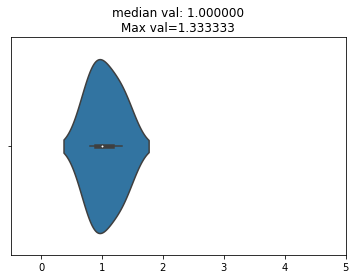

allquotients reshaped!

(3,)


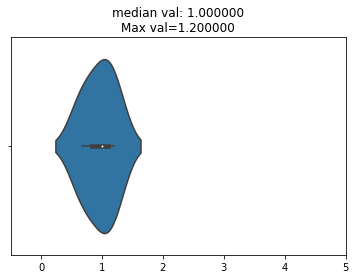

allquotients reshaped!

(3,)


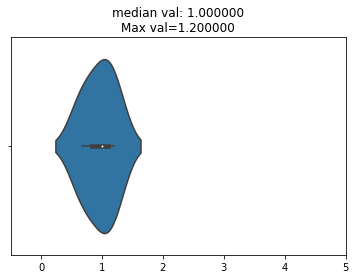

[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.16666667  0.33333333  0.5       ]]




[[ 4.  4.  4.]
 [ 4.  4.  4.]
 [ 2.  4.  6.]
 [ 2.  4.  6.]]


In [88]:
# TODO PQN normalization, and log-transformation, 
# and some feature selection (above certain threshold of intensity, use principal components), et

def pqn_normalize(X, integral_first=False, plot=False):
    '''
    Take a feature table and run PQN normalization on it
    '''
    # normalize by sum of intensities in each sample first. Not necessary
    if integral_first: 
        sample_sums = np.sum(X, axis=1)
        X = (X / sample_sums[:,np.newaxis])
    
    # Get the median value of each feature across all samples
    mean_intensities = np.median(X, axis=0)
    
    # Divde each feature by the median value of each feature - 
    # these are the quotients for each feature
    X_quotients = (X / mean_intensities[np.newaxis,:])
    
    if plot: # plot the distribution of quotients from one sample
        for i in range(1,len(X_quotients[:,1])):
            print 'allquotients reshaped!\n\n', 
            #all_quotients = X_quotients.reshape(np.prod(X_quotients.shape))
            all_quotients = X_quotients[i,:]
            print all_quotients.shape
            x = np.random.normal(loc=0, scale=1, size=len(all_quotients))
            sns.violinplot(all_quotients)
            plt.title("median val: %f\nMax val=%f" % (np.median(all_quotients), np.max(all_quotients)))
            plt.plot( title="median val: ")#%f" % np.median(all_quotients))
            plt.xlim([-0.5, 5])
            plt.show()

    # Define a quotient for each sample as the median of the feature-specific quotients
    # in that sample
    sample_quotients = np.median(X_quotients, axis=1)
    
    # Quotient normalize each samples
    X_pqn = X / sample_quotients[:,np.newaxis]
    return X_pqn

# Make a fake sample, with 2 samples at 1x and 2x dilutions
X_toy = np.array([[1,1,1,],
                  [2,2,2],
                  [3,6,9],
                  [6,12,18]], dtype=float)
print X_toy
print X_toy.reshape(1, np.prod(X_toy.shape))
X_toy_pqn_int = pqn_normalize(X_toy, integral_first=True, plot=True)
print X_toy_pqn_int

print '\n\n\n'
X_toy_pqn = pqn_normalize(X_toy)
print X_toy_pqn

<h2> pqn normalize your features </h2>

In [89]:
X_pqn = pqn_normalize(X)
print X_pqn

[[ 2456.54980525   870.34275561  2900.04553718 ...,  1207.0082228
    633.14275696   322.13186184]
 [ 2371.76317506    15.85731585  2628.91769897 ...,  1661.99841462
    995.21658354   386.88390829]
 [ 2421.76580034  1425.82765083  2855.39610211 ...,  2861.88345848
   1853.68539308   730.3256337 ]
 ..., 
 [  235.18194821   157.80692043   218.73606439 ...,   548.42339396
    254.20015991   241.12649328]
 [  218.61726942   146.69203271   203.32972613 ...,   509.79603574
    236.29596263   224.14311961]
 [  234.92742529   157.63613573   218.49933983 ...,   547.82986914
    253.92505475   240.86553695]]


In [90]:
def roc_curve_cv(X, y, clf, cross_val,
                path='/home/irockafe/Desktop/roc.pdf',
                save=False, plot=True):  
    t1 = time.time()
    # collect vals for the ROC curves
    tpr_list = []
    mean_fpr = np.linspace(0,1,100)
    auc_list = []
    
    # Get the false-positive and true-positive rate
    for i, (train, test) in enumerate(cross_val):
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[test])[:,1]
        
        # get fpr, tpr
        fpr, tpr, thresholds = roc_curve(y[test], y_pred)
        roc_auc = auc(fpr, tpr)
        #print 'AUC', roc_auc
        #sns.plt.plot(fpr, tpr, lw=10, alpha=0.6, label='ROC - AUC = %0.2f' % roc_auc,)
        #sns.plt.show()
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        tpr_list[-1][0] = 0.0
        auc_list.append(roc_auc)
        
        if (i % 10 == 0):
            print '{perc}% done! {time}s elapsed'.format(perc=100*float(i)/cross_val.n_iter, time=(time.time() - t1))
        
            
        
        
    # get mean tpr and fpr
    mean_tpr = np.mean(tpr_list, axis=0)
    # make sure it ends up at 1.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_list)
    
    if plot:
        # plot mean auc
        plt.plot(mean_fpr, mean_tpr, label='Mean ROC - AUC = %0.2f $\pm$ %0.2f' % (mean_auc, 
                                                                                       std_auc),
                    lw=5, color='b')

        # plot luck-line
        plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                    label='Luck', alpha=0.5) 

        # plot 1-std
        std_tpr = np.std(tpr_list, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                            label=r'$\pm$ 1 stdev')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve, {iters} iterations of {cv} cross validation'.format(
            iters=cross_val.n_iter, cv='{train}:{test}'.format(test=cross_val.test_size, train=(1-cross_val.test_size)))
                 )
        plt.legend(loc="lower right")

        if save:
            plt.savefig(path,  format='pdf')


        plt.show()
    return tpr_list, auc_list, mean_fpr

3
0.3
0.0% done! 4.88682699203s elapsed


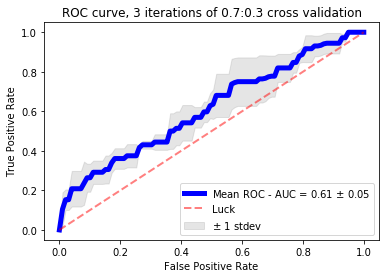

In [91]:


rf_estimators = 1000
n_iter = 3
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)
rf_graph_path = '''/home/irockafe/Dropbox (MIT)/Alm_Lab/
projects/revo_healthcare/notebooks/MTBLS17/
exploratory/rf_roc_{trees}trees_{cv}cviter.pdf'''.format(trees=rf_estimators, cv=n_iter)

print cross_val_rf.n_iter
print cross_val_rf.test_size

tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_pqn, y, clf_rf, cross_val_rf,
                                           path=rf_graph_path, save=False)

0.0% done! 7.10257506371s elapsed


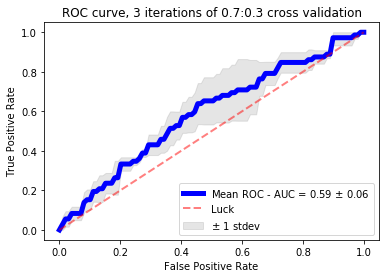

In [12]:
# For adaboosted
n_iter = 3
test_size = 0.3
random_state = 1
adaboost_estimators = 200
adaboost_path = '''/home/irockafe/Dropbox (MIT)/Alm_Lab/
projects/revo_healthcare/notebooks/MTBLS17/
exploratory/adaboost_roc_{trees}trees_{cv}cviter.pdf'''.format(trees=adaboost_estimators, 
                                                                            cv=n_iter)


cross_val_adaboost = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf = AdaBoostClassifier(n_estimators=adaboost_estimators, random_state=random_state)
adaboost_tpr, adaboost_auc, adaboost_fpr = roc_curve_cv(X_pqn, y, clf, cross_val_adaboost,
                                                       path=adaboost_path)

<h2> Classifier looks like garbage  </h2>

In [72]:
# Make a null model AUC curve

def make_null_model(X, y, clf, cross_val, random_state=1, num_shuffles=5, plot=True):
    '''
    Runs the true model, then sanity-checks by:
    
    Shuffles class labels and then builds cross-validated ROC curves from them.
    Compares true AUC vs. shuffled auc by t-test (assumes normality of AUC curve)
    '''
    null_aucs = []
    print y.shape
    print X.shape
    tpr_true, auc_true, fpr_true = roc_curve_cv(X, y, clf, cross_val)
    # shuffle y lots of times
    for i in range(0, num_shuffles):
        #Iterate through the shuffled y vals and repeat with appropriate params
        # Retain the auc vals for final plotting of distribution
        y_shuffle = shuffle(y)
        cross_val.y = y_shuffle
        cross_val.y_indices = y_shuffle
        print 'Number of differences b/t original and shuffle: %s' % (y == cross_val.y).sum()
        # Get auc values for number of iterations
        tpr, auc, fpr = roc_curve_cv(X, y_shuffle, clf, cross_val, plot=False)
        
        null_aucs.append(auc)
    
    
    #plot the outcome
    if plot:
        flattened_aucs = [j for i in null_aucs for j in i]
        my_dict = {'true_auc': auc_true, 'null_auc': flattened_aucs}
        df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
        df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                         value_name='auc', var_name='AUC_type')
        #print flattened_aucs
        sns.violinplot(x='AUC_type', y='auc',
            inner='points', data=df_tidy)
        # Plot distribution of AUC vals   
        plt.title("Distribution of aucs")
        #sns.plt.ylabel('count')
        plt.xlabel('AUC')
        #sns.plt.plot(auc_true, 0, color='red', markersize=10)
        plt.show()
    # Do a quick t-test to see if odds of randomly getting an AUC that good
    return auc_true, null_aucs


In [ ]:
# Make a null model AUC curve & compare it to null-model

# Random forest magic!
rf_estimators = 1000
n_iter = 50
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

true_auc, all_aucs = make_null_model(X_pqn, y, clf_rf, cross_val_rf, num_shuffles=5)

(262,)
(262, 1216)
0.0% done! 4.80081295967s elapsed
20.0% done! 50.7689909935s elapsed
40.0% done! 98.2501869202s elapsed


   AUC_type       auc
0  true_auc  0.886364
1  true_auc  0.965909
2  true_auc  0.704545
3  true_auc  0.772727
4  true_auc  0.909091


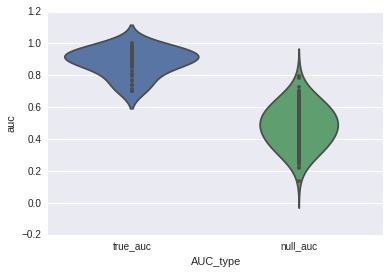

In [18]:
# make dataframe from true and false aucs
flattened_aucs = [j for i in all_aucs for j in i]
my_dict = {'true_auc': true_auc, 'null_auc': flattened_aucs}
df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                 value_name='auc', var_name='AUC_type')
print df_tidy.head()
#print flattened_aucs
sns.violinplot(x='AUC_type', y='auc',
    inner='points', data=df_tidy, bw=0.7)
plt.show()



<h2> Let's check out some PCA plots </h2>

[('red', 0, 'Cirrhosis'), ('blue', 1, 'Liver cancer')]
(184,)
(78,)


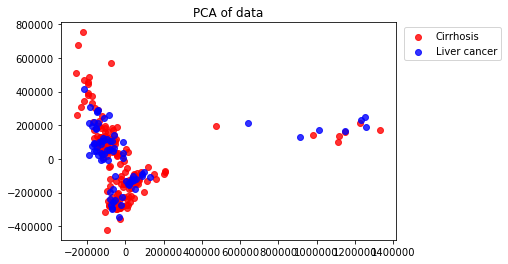

[('red', 0, 'Cirrhosis'), ('blue', 1, 'Liver cancer')]
(184,)
(78,)


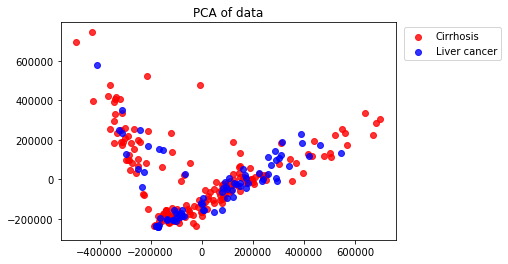

In [75]:
from sklearn.decomposition import PCA

# Check PCA of things
def PCA_plot(X, y, n_components, plot_color, class_nums, class_names, title='PCA'):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit(X).transform(X)

    print zip(plot_color, class_nums, class_names)
    for color, i, target_name in zip(plot_color, class_nums, class_names):
        # plot one class at a time, first plot all classes y == 0
        #print color
        #print y == i
        xvals = X_pca[y == i, 0]
        print xvals.shape
        yvals = X_pca[y == i, 1]
        plt.scatter(xvals, yvals, color=color, alpha=0.8, label=target_name)

    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', shadow=False)#, scatterpoints=1)
    plt.title('PCA of data')
    plt.show()


PCA_plot(X_pqn, y, 2, ['red', 'blue'], [0,1], ['Cirrhosis', 'Liver cancer'])
PCA_plot(X, y, 2, ['red', 'blue'], [0,1], ['Cirrhosis', 'Liver cancer'])

<h2> Look above. Top graph is after pqn-normalization. Looks like it does a good job... </h2>
Let's see if htere's any obvious clustering by batch

In [18]:
# Check PCA of things
def PCA_plot(X, y, n_components, plot_color, class_nums, class_names, title='PCA'):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit(X).transform(X)

    print zip(plot_color, class_nums, class_names)
    for color, i, target_name in zip(plot_color, class_nums, class_names):
        # plot one class at a time, first plot all classes y == 0
        #print color
        #print y == i
        xvals = X_pca[y == i, 0]
        print xvals.shape
        yvals = X_pca[y == i, 1]
        plt.scatter(xvals, yvals, color=color, alpha=0.8, label=target_name)

    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', shadow=False)#, scatterpoints=1)
    plt.title('PCA of data')
    plt.show()


    
print class_df['Factor Value[Experiment]']
#PCA_plot(X_pqn, y, 2, ['red', 'blue'], [0,1], ['Cirrhosis', 'Liver cancer'])
#PCA_plot(X, y, 2, ['red', 'blue'], [0,1], ['Cirrhosis', 'Liver cancer'])

0       Exp1
1       Exp1
2       Exp1
3       Exp1
4       Exp1
5       Exp1
6       Exp1
7       Exp1
8       Exp1
9       Exp1
10      Exp1
11      Exp1
12      Exp1
13      Exp1
14      Exp1
15      Exp1
16      Exp1
17      Exp1
18      Exp1
19      Exp1
20      Exp1
21      Exp1
22      Exp1
23      Exp1
24      Exp1
25      Exp1
26      Exp1
27      Exp1
28      Exp1
29      Exp1
        ... 
1020    Exp2
1021    Exp2
1022    Exp2
1023    Exp2
1024    Exp2
1025    Exp2
1026    Exp2
1027    Exp2
1028    Exp2
1029    Exp2
1030    Exp3
1031    Exp3
1032    Exp3
1033    Exp3
1034    Exp3
1035    Exp3
1036    Exp3
1037    Exp3
1038    Exp3
1039    Exp3
1040    Exp3
1041    Exp3
1042    Exp3
1043    Exp3
1044    Exp3
1045    Exp3
1046    Exp3
1047    Exp3
1048    Exp3
1049    Exp3
Name: Factor Value[Experiment], Length: 1050, dtype: object
